# Coulomb Interactions in Quantum Wires

:::{abstract}
This example demonstrates how to calculate Coulomb interactions in quantum wire systems using the `pulsesuite.PSTD3D.coulomb` module. We investigate unscreened and screened Coulomb matrices, energy renormalization effects, and many-body collision integrals.
:::

## Theory

The Coulomb module calculates electron-electron, hole-hole, and electron-hole Coulomb interactions in quantum wires. These interactions are essential for many-body effects in the Semiconductor Bloch Equations.

### Coulomb Interaction Potential

The Coulomb interaction between carriers in a quantum wire is given by:

$$
V(k, q) = \frac{e^2}{2\pi \epsilon_0 \epsilon_r L} \int dy_1 dy_2 \, \phi_e^*(y_1) \phi_h^*(y_2) \, K_0(|k-q|r) \, \phi_e(y_1) \phi_h(y_2)
$$

where $K_0$ is the modified Bessel function, $r = \sqrt{(y_1-y_2)^2 + \Delta_0^2}$ accounts for wire thickness, and $\phi_{e/h}$ are the confinement wavefunctions.

### Energy Renormalization

Many-body Coulomb interactions renormalize the energy levels:

**Band Gap Renormalization (BGR):**
$$
\Delta E_{gap} = -\sum_k [n_e(k) V_{ee}(k,k) + n_h(k) V_{hh}(k,k)]
$$

**Electron Energy Renormalization:**
$$
\Delta E_e(k) = \sum_{k'} n_e(k') [V_{ee}(k,k) - V_{ee}(k,k')]
$$

**Hole Energy Renormalization:**
$$
\Delta E_h(k) = \sum_{k'} n_h(k') [V_{hh}(k,k) - V_{hh}(k,k')]
$$

### Screening

The Coulomb interaction is screened by free carriers:

$$
V_{screened}(q) = \frac{V_{bare}(q)}{\epsilon(q, \omega)}
$$

where $\epsilon(q, \omega)$ is the dielectric function calculated from the carrier susceptibility.

### Many-Body Collision Terms

Beyond Hartree-Fock, the many-body collision terms (MBCE, MBCH) describe carrier-carrier scattering processes that lead to energy relaxation and dephasing.

## Setup and Initialization

First, we import the necessary modules and set up the physical parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulsesuite.PSTD3D import coulomb
from scipy.constants import e as e0, hbar

# Physical Parameters for GaAs Quantum Wire
L = 200e-9              # Wire length (m)
Delta0 = 5e-9           # Wire thickness (m)
N_y = 128               # Spatial grid points
N_k = 64                # Momentum grid points
m_e = 0.067 * 9.109e-31 # Electron effective mass (kg)
m_h = 0.45 * 9.109e-31  # Hole effective mass (kg)
epsr = 12.0             # Relative dielectric constant
ge = 1e12               # Electron dephasing rate (Hz)
gh = 1e12               # Hole dephasing rate (Hz)

# Confinement parameters (related to harmonic oscillator length)
HO = 0.1 * e0           # Energy level separation (J)
alphae = np.sqrt(m_e * HO) / hbar  # Electron confinement (1/m)
alphah = np.sqrt(m_h * HO) / hbar  # Hole confinement (1/m)

# Create spatial and momentum grids
y = np.linspace(-L/2, L/2, N_y)
ky = np.linspace(-2e8, 2e8, N_k)
dk = ky[1] - ky[0]

# Single-particle energies
E_e = hbar**2 * ky**2 / (2 * m_e)
E_h = hbar**2 * ky**2 / (2 * m_h)

print(f"Spatial grid: {y.min():.2e} to {y.max():.2e} m")
print(f"Momentum grid: {ky.min():.2e} to {ky.max():.2e} m^-1")
print(f"Electron confinement: {alphae:.2e} m^-1")
print(f"Hole confinement: {alphah:.2e} m^-1")

ModuleNotFoundError: No module named 'libpulsesuite'

## Momentum Difference Arrays

We need to set up momentum difference arrays for Coulomb calculations.

In [2]:
# Create momentum difference array Qy
# This represents all possible momentum differences |k - q|
N_Q = 2 * N_k - 1
Qy = np.zeros(N_Q)
Qy[0] = 0.0
for i in range(1, N_k):
    Qy[i] = i * dk
    Qy[N_Q - i] = -i * dk

# Create index mapping array kkp
# Maps (k, q) indices to Qy indices: kkp[k, q] = index of |ky[k] - ky[q]| in Qy
kkp = np.zeros((N_k, N_k), dtype=int)
for k in range(N_k):
    for q in range(N_k):
        Q_val = abs(ky[k] - ky[q])
        # Find closest index in Qy
        idx = np.argmin(np.abs(Qy - Q_val))
        kkp[k, q] = idx

print(f"Momentum difference array: {Qy.min():.2e} to {Qy.max():.2e} m^-1")
print(f"Index mapping array shape: {kkp.shape}")

NameError: name 'N_k' is not defined

## Initialize Coulomb Module

We initialize the Coulomb module, which sets up all internal arrays.

In [3]:
# Initialize Coulomb Module
# Note: screened parameter is passed but not used in initialization
screened = False  # We'll calculate screened arrays separately if needed

coulomb.InitializeCoulomb(
    y, ky, L, Delta0, m_e, m_h, E_e, E_h,
    ge, gh, alphae, alphah, epsr, Qy, kkp, screened
)

print("Coulomb module initialized")
print(f"Unscreened Coulomb arrays calculated")

NameError: name 'coulomb' is not defined

:::{note}
The `InitializeCoulomb` function sets up:
- `_UnDel`: Inverse delta function array for excluding self-interactions
- `_k3`: Momentum conservation indexing array
- `_qe`, `_qh`: Momentum difference arrays
- `_Ceh`, `_Cee`, `_Chh`: Many-body interaction arrays
- `_Veh0`, `_Vee0`, `_Vhh0`: Unscreened Coulomb matrices
- `_Chi1De`, `_Chi1Dh`: Susceptibility arrays for screening
:::

## Basic Interaction Integrals

We can calculate individual interaction integrals using `Vint` and `Vehint`.

In [4]:
# Calculate interaction integral for a specific momentum difference
Q_test = 1e8  # Momentum difference (1/m)

Vint_val = coulomb.Vint(Q_test, y, alphae, alphah, Delta0)

print(f"Interaction integral for Q = {Q_test:.2e} m^-1: {Vint_val:.2e}")

# Calculate electron-hole interaction for specific indices
k_idx = N_k // 2  # Center of k-grid
q_idx = N_k // 2  # Center of q-grid

Vehint_val = coulomb.Vehint(k_idx + 1, q_idx + 1, y, ky, alphae, alphah, Delta0)
# Note: Vehint uses 1-based indexing, so we add 1

print(f"Electron-hole interaction V({k_idx}, {q_idx}): {Vehint_val:.2e}")

NameError: name 'coulomb' is not defined

## Momentum Dependence of Interaction Integrals

Let's examine how the interaction integral depends on momentum difference.

In [5]:
# Calculate Vint for a range of momentum differences
Q_range = np.linspace(1e6, 5e8, 50)
Vint_range = np.zeros(len(Q_range))

for i, Q_val in enumerate(Q_range):
    Vint_range[i] = coulomb.Vint(Q_val, y, alphae, alphah, Delta0)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(Q_range/1e8, Vint_range, 'b-', linewidth=2)
ax.set_xlabel('Momentum Difference $|k-q|$ ($10^8$ m$^{-1}$)')
ax.set_ylabel('Interaction Integral')
ax.set_title('Coulomb Interaction Integral vs Momentum Difference')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'coulomb' is not defined

:::{note}
The interaction integral decreases with increasing momentum difference, reflecting the long-range nature of Coulomb interactions. At large momentum differences, the interaction is strongly suppressed.
:::

## Unscreened Coulomb Arrays

The unscreened Coulomb matrices are calculated during initialization. Let's examine them.

In [6]:
# Access the unscreened Coulomb arrays (stored as module-level variables)
# In a real workflow, these would be returned from CalcCoulombArrays
# For this example, we'll recalculate to show the interface

Veh0, Vee0, Vhh0 = coulomb.CalcCoulombArrays(
    y, ky, epsr, alphae, alphah, L, Delta0, Qy, kkp
)

print(f"Veh0 shape: {Veh0.shape}")
print(f"Vee0 shape: {Vee0.shape}")
print(f"Vhh0 shape: {Vhh0.shape}")
print(f"Veh0 range: {Veh0.min():.2e} to {Veh0.max():.2e} J")
print(f"Vee0 range: {Vee0.min():.2e} to {Vee0.max():.2e} J")
print(f"Vhh0 range: {Vhh0.min():.2e} to {Vhh0.max():.2e} J")

NameError: name 'coulomb' is not defined

## Visualization of Coulomb Matrices

We visualize the Coulomb interaction matrices.

NameError: name 'Veh0' is not defined

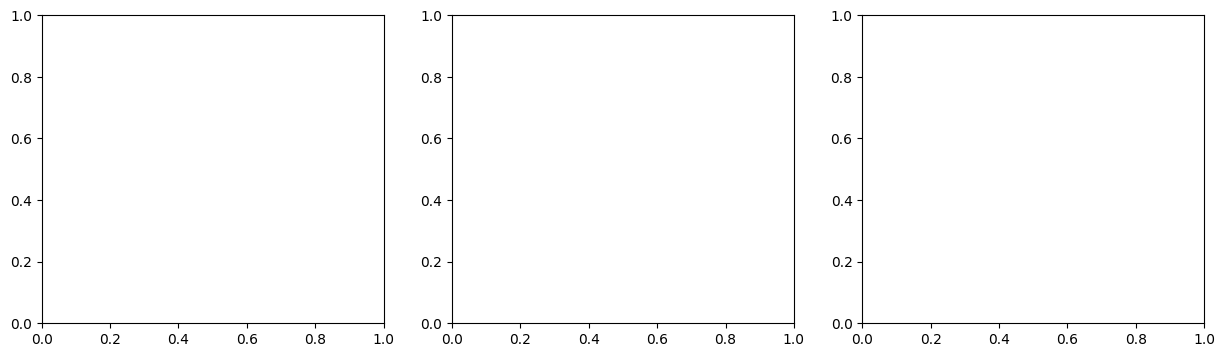

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Electron-hole interaction
im1 = axes[0].imshow(Veh0, aspect='auto', origin='lower',
                     extent=[ky.min()/1e8, ky.max()/1e8, ky.min()/1e8, ky.max()/1e8])
axes[0].set_xlabel('$q$ ($10^8$ m$^{-1}$)')
axes[0].set_ylabel('$k$ ($10^8$ m$^{-1}$)')
axes[0].set_title('Electron-Hole Interaction $V_{eh}(k,q)$')
plt.colorbar(im1, ax=axes[0], label='Energy (J)')

# Electron-electron interaction
im2 = axes[1].imshow(Vee0, aspect='auto', origin='lower',
                     extent=[ky.min()/1e8, ky.max()/1e8, ky.min()/1e8, ky.max()/1e8])
axes[1].set_xlabel('$q$ ($10^8$ m$^{-1}$)')
axes[1].set_ylabel('$k$ ($10^8$ m$^{-1}$)')
axes[1].set_title('Electron-Electron Interaction $V_{ee}(k,q)$')
plt.colorbar(im2, ax=axes[1], label='Energy (J)')

# Hole-hole interaction
im3 = axes[2].imshow(Vhh0, aspect='auto', origin='lower',
                     extent=[ky.min()/1e8, ky.max()/1e8, ky.min()/1e8, ky.max()/1e8])
axes[2].set_xlabel('$q$ ($10^8$ m$^{-1}$)')
axes[2].set_ylabel('$k$ ($10^8$ m$^{-1}$)')
axes[2].set_title('Hole-Hole Interaction $V_{hh}(k,q)$')
plt.colorbar(im3, ax=axes[2], label='Energy (J)')

plt.tight_layout()
plt.show()

:::{note}
The Coulomb matrices show the strongest interactions near the diagonal (small momentum differences), consistent with the long-range nature of Coulomb forces. The electron-hole interaction is typically the strongest due to the attractive nature of opposite charges.
:::

## Energy Renormalization

We calculate energy renormalization due to many-body Coulomb effects.

In [8]:
# Create carrier distributions
sigma_k = 1e8
n_e = np.exp(-ky**2 / (2 * sigma_k**2)) + 0j
n_h = np.exp(-ky**2 / (2 * sigma_k**2)) + 0j
n_e /= np.sum(n_e)  # Normalize
n_h /= np.sum(n_h)  # Normalize

# Create density matrices (diagonal for this example)
C = np.diag(n_e)
D = np.diag(n_h)

# Create VC array (unscreened for now)
VC = np.zeros((N_k, N_k, 3))
VC[:, :, 0] = Veh0  # Electron-hole
VC[:, :, 1] = Vee0  # Electron-electron
VC[:, :, 2] = Vhh0  # Hole-hole

# Calculate band gap renormalization
BGR = np.zeros((N_k, N_k), dtype=complex)
coulomb.BGRenorm(C, D, VC, BGR)

# Extract diagonal elements (k=k' terms)
BGR_diag = np.diag(BGR)

print(f"Band gap renormalization range: {BGR_diag.min()/e0*1e3:.3f} to {BGR_diag.max()/e0*1e3:.3f} meV")
print(f"Average BGR: {np.mean(BGR_diag)/e0*1e3:.3f} meV")

NameError: name 'ky' is not defined

## Electron and Hole Energy Renormalization

We calculate individual energy renormalizations for electrons and holes.

In [9]:
# Electron energy renormalization
EeRenorm = np.zeros((N_k, N_k), dtype=complex)
coulomb.EeRenorm(n_e, VC, EeRenorm)
EeRenorm_diag = np.diag(EeRenorm)

# Hole energy renormalization
EhRenorm = np.zeros((N_k, N_k), dtype=complex)
coulomb.EhRenorm(n_h, VC, EhRenorm)
EhRenorm_diag = np.diag(EhRenorm)

print(f"Electron energy renormalization: {EeRenorm_diag.min()/e0*1e3:.3f} to {EeRenorm_diag.max()/e0*1e3:.3f} meV")
print(f"Hole energy renormalization: {EhRenorm_diag.min()/e0*1e3:.3f} to {EhRenorm_diag.max()/e0*1e3:.3f} meV")

# Visualize renormalization effects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(ky/1e8, E_e/e0*1e3, 'b--', label='Unrenormalized', linewidth=2)
ax.plot(ky/1e8, (E_e + EeRenorm_diag.real)/e0*1e3, 'b-', label='Renormalized', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Energy (meV)')
ax.set_title('Electron Energy Renormalization')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(ky/1e8, E_h/e0*1e3, 'g--', label='Unrenormalized', linewidth=2)
ax.plot(ky/1e8, (E_h + EhRenorm_diag.real)/e0*1e3, 'g-', label='Renormalized', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Energy (meV)')
ax.set_title('Hole Energy Renormalization')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'N_k' is not defined

:::{note}
Energy renormalization shifts the energy bands, with the shift depending on the carrier density. Higher carrier densities lead to larger renormalization effects due to increased Coulomb interactions.
:::

## Screening

We calculate screened Coulomb interactions, which account for the dielectric response of free carriers.

In [10]:
# Create VC array with unscreened values
VC_screened = np.zeros((N_k, N_k, 3))
VC_screened[:, :, 0] = Veh0
VC_screened[:, :, 1] = Vee0
VC_screened[:, :, 2] = Vhh0

# Dielectric function array
E1D = np.zeros((N_k, N_k))

# Calculate screened arrays
coulomb.CalcScreenedArrays(True, L, np.real(n_e), np.real(n_h), VC_screened, E1D)

print(f"Screened Veh range: {VC_screened[:, :, 0].min():.2e} to {VC_screened[:, :, 0].max():.2e} J")
print(f"Dielectric function range: {E1D.min():.2f} to {E1D.max():.2f}")

# Compare screened vs unscreened
Veh_screened = VC_screened[:, :, 0]
Veh_unscreened = Veh0

# Compare along diagonal
k_diag = np.arange(N_k)
Veh_unscreened_diag = Veh_unscreened[k_diag, k_diag]
Veh_screened_diag = Veh_screened[k_diag, k_diag]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(ky/1e8, Veh_unscreened_diag/e0*1e3, 'b-', label='Unscreened', linewidth=2)
ax.plot(ky/1e8, Veh_screened_diag/e0*1e3, 'r--', label='Screened', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Interaction Energy (meV)')
ax.set_title('Screened vs Unscreened Electron-Hole Interaction')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.imshow(E1D, aspect='auto', origin='lower',
         extent=[ky.min()/1e8, ky.max()/1e8, ky.min()/1e8, ky.max()/1e8])
ax.set_xlabel('$q$ ($10^8$ m$^{-1}$)')
ax.set_ylabel('$k$ ($10^8$ m$^{-1}$)')
ax.set_title('Dielectric Function $\\epsilon(k,q)$')
plt.colorbar(ax=axes[1], label='Dielectric Constant')

plt.tight_layout()
plt.show()

NameError: name 'N_k' is not defined

:::{tip}
Screening reduces the effective Coulomb interaction, especially at small momentum differences. This is important for high carrier densities where the free carriers screen the bare Coulomb potential.
:::

## Many-Body Collision Terms

The many-body collision terms (MBCE, MBCH) describe carrier-carrier scattering beyond Hartree-Fock. These are used in full SBE calculations.

In [11]:
# Many-body collision terms require initialized arrays from InitializeCoulomb
# These are advanced calculations typically used in SBE time evolution

# For demonstration, we'll show the interface
# In practice, these would be called during SBE integration

Win_e = np.zeros(N_k)
Wout_e = np.zeros(N_k)
Win_h = np.zeros(N_k)
Wout_h = np.zeros(N_k)

# Note: MBCE and MBCH use 1-based indexing for carrier arrays
# We need to pad arrays with a 0th element
ne_padded = np.zeros(N_k + 1)
nh_padded = np.zeros(N_k + 1)
ne_padded[1:] = np.real(n_e)
nh_padded[1:] = np.real(n_h)

# Calculate many-body collision terms for electrons
coulomb.MBCE2(ne_padded, nh_padded, ky, E_e, E_h, VC_screened,
              ge, ge, Win_e, Wout_e)

# Calculate many-body collision terms for holes
coulomb.MBCH(ne_padded, nh_padded, ky, E_e, E_h, VC_screened,
             ge, gh, Win_h, Wout_h)

print(f"Electron in-scattering rate range: {Win_e.min():.2e} to {Win_e.max():.2e} s^-1")
print(f"Electron out-scattering rate range: {Wout_e.min():.2e} to {Wout_e.max():.2e} s^-1")
print(f"Hole in-scattering rate range: {Win_h.min():.2e} to {Win_h.max():.2e} s^-1")
print(f"Hole out-scattering rate range: {Wout_h.min():.2e} to {Wout_h.max():.2e} s^-1")

# Visualize scattering rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(ky/1e8, Win_e, 'b-', label='In-scattering', linewidth=2)
ax.plot(ky/1e8, Wout_e, 'r--', label='Out-scattering', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Scattering Rate (s$^{-1}$)')
ax.set_title('Electron Many-Body Scattering Rates')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
ax.plot(ky/1e8, Win_h, 'g-', label='In-scattering', linewidth=2)
ax.plot(ky/1e8, Wout_h, 'orange', linestyle='--', label='Out-scattering', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Scattering Rate (s$^{-1}$)')
ax.set_title('Hole Many-Body Scattering Rates')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'N_k' is not defined

:::{note}
The many-body collision terms describe energy relaxation and dephasing processes due to carrier-carrier scattering. These are essential for realistic SBE simulations but are computationally intensive.
:::

## Assumptions and Parameter Choices

This section explains the assumptions and rationale behind the parameter values chosen for this example.

### Material Parameters (GaAs)

**Effective masses:**
- `m_e = 0.067 * m_0`: Electron effective mass for GaAs (bulk value)
- `m_h = 0.45 * m_0`: Heavy hole effective mass for GaAs (bulk value)
- **Rationale**: Standard GaAs bulk values. Quantum confinement may modify these, but bulk values are reasonable for demonstration.

**Dielectric constant:**
- `epsr = 12.0`: Relative permittivity for GaAs
- **Rationale**: GaAs value (~12.9 at low frequency). Using 12.0 for simplicity.

**Wire dimensions:**
- `L = 200e-9 m`: Wire length (200 nm)
- `Delta0 = 5e-9 m`: Wire thickness (5 nm)
- **Rationale**: Typical quantum wire dimensions. The thickness affects the Coulomb interaction strength through the $r = \sqrt{(y_1-y_2)^2 + \Delta_0^2}$ term.

### Confinement Parameters

**Energy level separation:**
- `HO = 0.1 eV`: Harmonic oscillator energy separation
- **Rationale**: Typical value for quantum wire confinement. This determines the confinement parameters `alphae` and `alphah`.

**Confinement parameters:**
- `alphae = sqrt(m_e * HO) / hbar`: Electron confinement wavevector
- `alphah = sqrt(m_h * HO) / hbar`: Hole confinement wavevector
- **Rationale**: Derived from harmonic oscillator model. These determine the spatial extent of carrier wavefunctions.

### Grid and Numerical Parameters

**Spatial grid:**
- `N_y = 128`: Number of spatial points
- **Rationale**: Sufficient resolution for integration while keeping computation time reasonable.

**Momentum grid:**
- `N_k = 64`: Number of momentum points
- `k_range = [-2e8, 2e8] m^-1`: Momentum range
- **Rationale**: 64 points balances resolution and speed. Range covers relevant k-space for transitions near the band gap.

**Momentum difference array:**
- `N_Q = 2*N_k - 1`: All possible momentum differences
- **Rationale**: Includes all combinations of k and q values.

### Simplifications

**Carrier distributions:**
- Gaussian distributions centered at k=0
- **Rationale**: Simple, symmetric distribution representing photoexcited carriers. Realistic distributions would come from SBE evolution.

**Static distributions:**
- Carrier densities do not evolve in time
- **Rationale**: Demonstrates the Coulomb calculation interface. Full simulations would evolve carriers via SBEs.

**Density matrices:**
- Diagonal density matrices (no off-diagonal coherence)
- **Rationale**: Simplifies the example. Full SBE calculations include off-diagonal elements.

### Screening

**Screening calculation:**
- Uses simplified 1D dielectric function
- **Rationale**: Full frequency-dependent screening is more complex. The 1D approximation is reasonable for quantum wires.

:::{warning}
**Important Limitations:**
1. **Carrier evolution**: Distributions are static. Full simulations require coupling with the SBE solver.
2. **Off-diagonal coherence**: Only diagonal density matrices are used. Full SBE calculations include off-diagonal elements.
3. **Frequency-dependent screening**: Uses static screening approximation. Dynamic screening requires frequency-dependent dielectric function.
4. **Material parameters**: Bulk GaAs values. Confined systems may need adjusted parameters.
:::

## Summary

This example demonstrated:

1. **Initialization** of the Coulomb module with spatial and momentum grids
2. **Basic interaction integrals** (`Vint`, `Vehint`) for individual momentum pairs
3. **Unscreened Coulomb arrays** (`CalcCoulombArrays`) for electron-hole, electron-electron, and hole-hole interactions
4. **Energy renormalization** (`BGRenorm`, `EeRenorm`, `EhRenorm`) accounting for many-body effects
5. **Screening effects** (`CalcScreenedArrays`) reducing Coulomb interactions at high carrier densities
6. **Many-body collision terms** (`MBCE`, `MBCH`) for carrier-carrier scattering

The `coulomb` module provides a comprehensive framework for calculating Coulomb interactions in quantum wires, including unscreened and screened interactions, energy renormalization, and many-body collision terms essential for realistic SBE simulations.